In [26]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from types import SimpleNamespace
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import os

In [29]:
def save_fig(fig_name, filetype="png", dpi=300):
    '''
    Save the current matplotlib figure.

    Args
    name (string): figure name
    filetype (string): file type
    dpi (int): dots per inch
    '''
    save_dir = '/home/za9132/amr-gpu/figures'
    filename = "%s.%s" % (fig_name, filetype)
    plt.savefig(os.path.join(save_dir, filename), bbox_inches="tight", dpi=dpi)
    print('Saved figure')

In [14]:
with open('grid.csv', 'r') as f:
    lines = f.readlines()
    key_list = [key.strip('\n') for key in lines[0].split(',')]
    grid = {key: [] for key in key_list}
    for line in lines[1:]:
        line_split = line.split(",")
        for i, datum in enumerate(line_split):
            grid[key_list[i]].append(float(datum))

grid = {key: np.array(value) for (key, value) in grid.items()}
grid = SimpleNamespace(**grid)
grid.dx = 1 / 2**grid.L
grid.x = grid.i * grid.dx + grid.dx / 2
grid.y = grid.j * grid.dx + grid.dx / 2
grid.z = grid.k * grid.dx + grid.dx / 2
grid.r = np.sqrt((grid.x - 0.5)**2 + (grid.y - 0.5)**2 + (grid.z - 0.5)**2)


In [9]:
# check that leaf cells sum to unity
np.sum(grid.dx[grid.flag_leaf == 1]**3)


1.00439453125

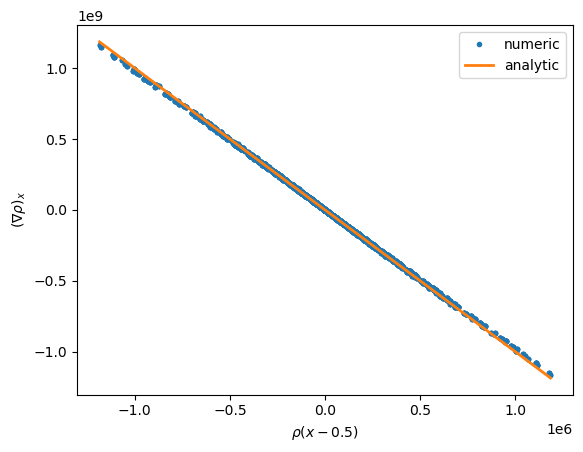

In [10]:
sigma = 0.001
rho_xm0p5 = (grid.rho * (grid.x - 0.5))[grid.flag_leaf == 1]
plt.plot(rho_xm0p5, grid.rho_grad_x[grid.flag_leaf == 1], '.', label='numeric')

x_space = np.linspace(np.min(rho_xm0p5), np.max(rho_xm0p5))
plt.plot(x_space, -x_space / sigma, lw=2, label='analytic')

plt.xlabel(r"$\rho (x - 0.5)$")
plt.ylabel(r"$(\nabla \rho)_x$")
plt.legend()


In [24]:
def plot_rho_slice(z, num=50, **kwargs):
    coord_min = [coord - 1 / 2**(grid.L + 1) for coord in [grid.x, grid.y, grid.z]]
    coord_max = [coord + 1 / 2**(grid.L + 1) for coord in [grid.x, grid.y, grid.z]]
    cond = (z >= coord_min[2]) * (z <= coord_max[2])
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num), np.linspace(0, 1, num), indexing='ij')
    rho_grid = griddata((grid.x[cond], grid.y[cond]), grid.rho[cond], (x_grid, y_grid), fill_value=0)
    im = plt.contourf(x_grid, y_grid, rho_grid, **kwargs)
    return im

def plot_grid_slice(z, color='black'):
    coord_min = [coord - 1 / 2**(grid.L + 1) for coord in [grid.x, grid.y, grid.z]]
    coord_max = [coord + 1 / 2**(grid.L + 1) for coord in [grid.x, grid.y, grid.z]]
    cond = (z >= coord_min[2]) * (z <= coord_max[2])
    plt.plot(np.array([coord_min[0][cond], coord_min[0][cond], coord_max[0][cond], coord_max[0][cond], coord_min[0][cond]]), np.array([coord_min[1][cond], coord_max[1][cond], coord_max[1][cond], coord_min[1][cond], coord_min[1][cond]]), color=color, lw=0.5)

Saved figure


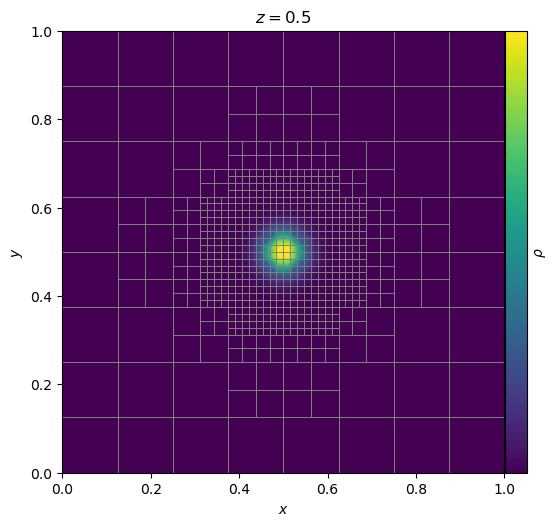

In [30]:
fig = plt.figure(figsize=(6, 6))

z = 0.5
im = plot_rho_slice(z, levels=200)
plot_grid_slice(z, color='grey')

plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = %.3g$' % z)

cbar_ticks = []
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.01)
plt.colorbar(im, cax=cax, ticks=cbar_ticks, label=r"$\rho$")

save_fig('grid')


Text(0, 0.5, '$N_{\\rm cells}$')

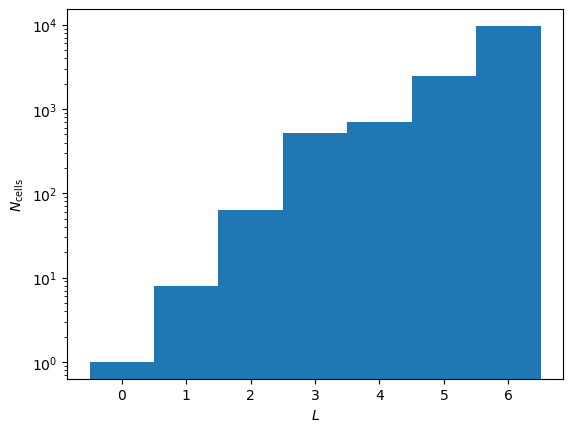

In [59]:
plt.hist(grid.L, bins=np.arange(-0.5, 7))

plt.yscale('log')
plt.xlabel(r'$L$')
plt.ylabel(r'$N_{\rm cells}$')